In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [16]:
class GridEnv(gym.Env):
    """Custom Environment for Grid World"""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, grid, start, goal, max_steps):
        super().__init__()
        self.grid = np.array(grid, dtype=np.int8)
        self.size = self.grid.shape[0]
        self.start = start
        self.goal  = goal
        self.max_steps = max_steps
        self.current_step = 0
        self.agent_position = list(self.start)
        self.action_space = spaces.Discrete(4) # up, down, left, right
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, self.size, self.size), dtype=np.uint8) # 0: free space, 255: obstacle, 64: agent, 128: goal


    def step(self, action):
        self.current_step += 1
        next_position = list(self.agent_position)
        
        if action == 0: next_position[0] -= 1 # up
        elif action == 1: next_position[0] += 1 # down
        elif action == 2: next_position[1] -= 1 # left
        elif action == 3: next_position[1] += 1 # right
        
        collision = False
        if 0 <= next_position[0] < self.size and 0 <= next_position[1] < self.size and self.grid[next_position[0], next_position[1]] == 0:
            self.agent_position = np.array(next_position, copy=True)
        else:
            collision = True

        obs = np.zeros((self.size, self.size), dtype=np.uint8)
        obs[self.grid == 1] = 255          # obstacles
        obs[self.goal] = 128              # goal
        obs[self.agent_position[0], self.agent_position[1]] = 64  # agent

        observation = obs[np.newaxis, :, :] # shape to (1, Size, Size)
        terminated = np.array_equal(self.agent_position, self.goal)
        truncated = self.current_step >= self.max_steps

        reward = 0
        if terminated:
            reward += 1
        elif collision:
            reward -= 1
        else:
            reward -= 0.001
        
        info = {}

        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        obs = np.zeros((self.size, self.size), dtype=np.uint8)
        obs[self.grid == 1] = 255        # obstacles
        obs[self.goal] = 128              # goal
        obs[self.start] = 64  # agent

        observation = obs[np.newaxis, :, :] # shape to (1, Size, Size)
        self.agent_position = list(self.start)
        self.current_step = 0
        info = {}
        
        return observation, info

    def render(self):
        obs = np.zeros((self.size, self.size), dtype=np.uint8)
        obs[self.grid == 1] = 255          # obstacles
        obs[self.goal] = 128              # goal
        obs[self.agent_position[0], self.agent_position[1]] = 64  # agent

        observation = obs

        symbols = {0: '.', 1: '#', 2: 'A', 3: 'G'}
        print("\n".join(" ".join(symbols.get(v, '?') for v in row) for row in observation))
        print()

        
       

1.0


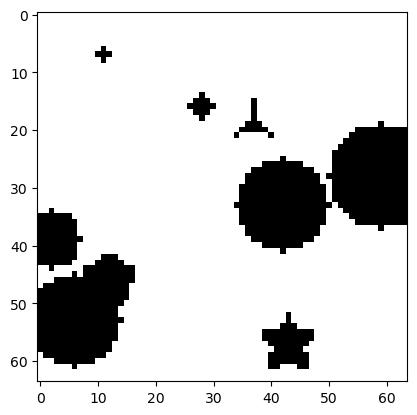

In [17]:
loaded = np.load('environments/environments_10_objects.npy')
loaded.shape

grid = loaded[0]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [19]:
start = (0,0)
goal = (63,63)
max_steps = 5000




from stable_baselines3 import A2C, PPO, DQN
env = GridEnv(grid, start, goal, max_steps)
# Define and Train the agent
model = PPO("CnnPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/").learn(total_timesteps=500000)

In [20]:
n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:  # VecEnv returns arrays
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 100/100 [05:16<00:00,  3.16s/it]

terminated:  0.0 %
